# Real-time exposure monitoring (rtxm)
<h3>An R pseudo-package for fitting real-time exposure models</h3>

This pseudo-package provides software for the class of models described in [Houseman and Virji (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5712446/), *A Bayesian Approach for Summarizing and Modeling Time-Series Exposure Data with Left Censoring*.

In particular, the software fits the following model:

\begin{equation}
Y_{ir} = \alpha (task_{ir}) + \mathbf{\mathrm{x}}_{ir}^t \mathbf{\beta}+f_{i}(time_{ir})+\varepsilon_{ir}
\end{equation}

where $i$ indexes a subject (e.g. an employee), $r$ indexes a sequential measurement within the profile corresponding to subject $i$, $Y_{ir}$ is the measured value (or its logarithm), measured at time $time_{ir}$, $\alpha (task_{ir})$ is the conditional mean of the task being performed at $time_{ir}$ (one of a set of finite tasks), $f_{i}(t)$ is a subject-specific trajectory accounting for nonstationary temporal autocorrelation across the time period, and $\varepsilon_{ir}$ is a additional error term whose variance depends on the task being performed (i.e. $task_{ir}$). Note that $Y_{ir}$ may be left-censored (i.e. subject to detection limits). In this model, $f_{i}(t)$ is realized using an appropriately regularized B-spline representation.  See the published paper for details.

**This particular notebook demonstrates functionality that slightly extends the method  discussed in the original article.**  In the original article the spline coefficients for $f_{i}(t)$ were assumed to be identically normally distributed but independent.  This extension assumes that the coefficients are dependent via an AR-1 structure.

The method has been used in [Virji, Liang et al. (2019)](https://academic.oup.com/annweh/advance-article-pdf/doi/10.1093/annweh/wxz043/28761303/wxz043.pdf), *Peaks, Means, and Determinants of Real-Time TVOC Exposures Associated with Cleaning and Disinfecting Tasks in Healthcare Settings*.

A release of the current version can be found [here](https://github.com/eahouseman/rtxm).  In particular, the read-me for the current release can be found [here](https://github.com/eahouseman/rtxm/blob/master/README.md).  
This notebook demonstrates in detail Example 14 of the release.

**Note**:  You may want to consider running [Example 4](https://github.com/eahouseman/rtxm/blob/master/rtxm-example04.ipynb) before this one, as it contains more detailed explanation of some of the steps.

In [1]:
#####################################################################
# EXAMPLE 14 (2018 November 12)
#
# This demonstrates the random intercept model (nondetects, variable LODs, covariates)
#   In this example, the variance-covariance matrix for the spline coefficients
#   are not assumed to be independent, but instead have an AR-1 structure.
#
# The model demonstrated here is a simple extension of rtxmProfileREffLODsCovariatesModel.
# Extensions are also available for rtxmProfileREffCovariatesModel, 
#    rtxmBasicLODsCovariatesModel, and rtxmBasicCovariatesModel.
#  See corresponding examples for these models, but use these constructor functions
#    instead: rtxmProfileREffCovariatesModelAR1Zeta, 
#    rtxmBasicLODsCovariatesModelAR1Zeta, and rtxmBasicCovariatesModelAR1Zeta.
#####################################################################

# Change working directory to an appropriate location
setwd('C:\\Users\\eahou\\Documents\\Virji\\rtxm')

source("rtxm.R") # Functions that will comprise the package
source("rtxmARExtensions.R")

Warning message:
"package 'rjags' was built under R version 3.6.1"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.6.1"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [2]:
###################################################
# Read data
load("rtxmSampleData.RData")
theData <- sample_data
head(theData)

###################################################
#  Get time data and create "time/employee" profiles
#    Note:  to understand the second argument, 
#           see help for base function "strptime"
theDataDateTime <- rtxmParseDateTime(theData$DateTime, "%d%b%Y:%H:%M:%S")
head(theDataDateTime)

# Concatenated location / sample date 
#  (will function as a "profile" for this example)
theData$Profile <- paste(theData$Location, theDataDateTime$date, sep=":")
head(theData$Profile)

###################################################
# Fix duplicates

# These are possile duplicates, as judged by their having the same
#  time stamp and reading values
possDups <- rtxmFindDuplicates(theData$lnY, theData$Profile, theDataDateTime$time.days)
possDups

# Remove duplicates (would fix if there were duplicates)
theData <- rtxmFixDuplicates(possDups, theData)

###################################################
#  Create spline basis
#  (B-spline basis with knots based on quantiles obtained by
#    attempting to place 8 knots per hour in the support of the time distribution)
theSplineBasis <- rtxmMakeBspline(theDataDateTime$time.days, 8)

###################################################
#  Fake non-detect data
theData$LODs <- log(runif(dim(theData)[1],20,30))
theData$lnYND <- pmax(theData$LODs, theData$lnY)

###################################################
#  Create model object
myModel <- rtxmProfileREffLODsCovariatesModelAR1Zeta(
  ~lnYND,                                 # Response (Y) 
  ~TaskID,                                # Task (factor variable)
  theSplineBasis,                         # Spline basis object (see above)
  LOD=theData$LODs,                       # LODs (on same scale as Y)
  zCovariates=~Source_enclosure+Volume,   # Covariate model
  data=theData,                           # Data set to interpret variables
  gGroup=~Profile                         # Series (profile) identifier
)

update(myModel,500)  # Adaptation
update(myModel,5000)  # Burn-in
myModel

showJAGS(myModel)

###################################################
#  Collect MCMC samples

system.time(update(myModel,100,"$standard",10)) # Test run with 100
myModel

update(myModel,10000,"$standard",10) # 10000 samples thinned by 10
myModel


TaskID,Location,DateTime,Source_enclosure,lnY,Material,Material_form,Volume,Var1,Var2,Var3
Task3,Location2,15MAR2016:09:42:39,Yes,4.475609,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:45:39,Yes,4.293304,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:48:39,Yes,4.451700,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:51:39,Yes,4.785629,Mat2,MatForm2,49,yes,2,No
Task3,Location2,15MAR2016:09:54:39,Yes,5.176517,Mat2,MatForm2,49,yes,2,No
Task4,Location2,15MAR2016:09:57:39,Yes,5.545958,Mat4,MatForm2,36,yes,2,No


date,day.year,day.month,day.monthDay,day.yearDay,time.days
2016-3-15,2016,2,15,74,0.4046181
2016-3-15,2016,2,15,74,0.4067014
2016-3-15,2016,2,15,74,0.4087847
2016-3-15,2016,2,15,74,0.4108681
2016-3-15,2016,2,15,74,0.4129514
2016-3-15,2016,2,15,74,0.4150347


[1] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"
[4] "Location2:2016-3-15" "Location2:2016-3-15" "Location2:2016-3-15"

list()

Warning message in rtxmFixDuplicates(possDups, theData):
"There are no duplicates to fix!"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 157
   Unobserved stochastic nodes: 221
   Total graph size: 13750

Initializing model

500 TRUE 


Model for real-time exposure monitoring
(Random profile effect, Nondetects, variable LODs, covariates, AR-1 zeta covariance) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limits-of-detection: ( 3.106614 -| 3.220075 |- 3.312416 )
Percent non-detect: 6.5 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpEXHhyj\file28a8d2a4157 

Markov-Chain Monte-Carlo status: adapted/burn-in 
Markov-Chain Monte-Carlo burn-in: 5000 

model{
        tauZ ~ dnorm(0,1.0E-6)T(0,1.0E10)
        tauA ~ dnorm(0,1.0E-6)T(0,1.0E10)
        rho ~ dunif(-0.9999,0.9999)
        tauZinnovation <- tauZ / (1-rho*rho)

        beta0 ~ dnorm(0,BETA0PRECISION)

        for(it in 1:Nprofile){
          zeta[it,1] ~ dnorm(0, tauZ)
          zetaInnovation[it,1] ~ dnorm(0, tauZinnovation)
          for(j in 2:D){
            zetaInnovation[it,j] ~ dnorm(0, tauZinnovation)
            zeta[it,j] <- zeta[it,j-1]*rho + zetaInnovation[it,j]
          }
          alpha[it] ~ dnorm(beta0, tauA)
        }

        for(h in 1:Nsample){
          muTimedep[h] <- inprod(spline[h,1:D],zeta[idProfile[h],1:D])
          muExtra[h] <- inprod(covariates[h,1:nCovariates], xi[1:nCovariates])
          muTask[h] <-  alpha[idProfile[h]] + inprod(task[h,1:P],beta[1:P])
          mu[h] <-  muTimedep[h] + muTask[h] + muExtra[h]
        }

        for(g1 in 1:NDetect){
          yDetect[g1] ~ dnorm(mu[detectIndex[g1]], tauE[idTask[detectIndex[g1]]])
        

   user  system elapsed 
   0.42    0.00    0.42 

Model for real-time exposure monitoring
(Random profile effect, Nondetects, variable LODs, covariates, AR-1 zeta covariance) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limits-of-detection: ( 3.106614 -| 3.220075 |- 3.312416 )
Percent non-detect: 6.5 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpEXHhyj\file28a8d2a4157 

Markov-Chain Monte-Carlo status: sampling block 1 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
    N thin                                              variables
1 100   10 alpha,beta,beta0,rho,tauA,tauE,tauZ,xi,yNonDetect,zeta

Model for real-time exposure monitoring
(Random profile effect, Nondetects, variable LODs, covariates, AR-1 zeta covariance) 

Observations: 168 
Tasks: 5 
Profiles: 3 

Hyperparameters:
 BETAPRECISION BETA0PRECISION    XIPRECISION 
         1e-04          1e-04          1e-04 

Spline basis functions: 63 
Spline boundary: 0 1 
Knots: n=60, density in support: 8 per hour

Limits-of-detection: ( 3.106614 -| 3.220075 |- 3.312416 )
Percent non-detect: 6.5 

Local file containing model definition: C:\Users\eahou\AppData\Local\Temp\RtmpEXHhyj\file28a8d2a4157 

Markov-Chain Monte-Carlo status: sampling block 2 
Markov-Chain Monte-Carlo burn-in: 5000 

Sample history:
      N thin                                              variables
1   100   10 alpha,beta,beta0,rho,tauA,tauE,tauZ,xi,yNonDetect,zeta
2 10000   10 alpha,beta,beta0,rho,tauA,tauE,tauZ,xi,yNonDetect,zeta

In [3]:
###################################################
# Output and graphics
print(summary(myModel))  # Model summary


$`fixed effects`
                          mean          sd        2.5%        50%      97.5%
(Intercept)         12.6777070 0.350961048 12.06146344 12.7100363 13.2432091
Task2                2.7461288 0.225854852  2.31571261  2.7364589  3.1818123
Task3                2.7012254 0.206141296  2.29602699  2.7025134  3.1014505
Task4                0.1047034 0.094530745 -0.09393468  0.1050730  0.2886611
Task5                6.1487258 0.406615235  5.47039128  6.1122887  6.9663161
Source_enclosureYes  0.2179503 0.138000397 -0.03491707  0.2126840  0.4832122
Volume              -0.2173607 0.009644126 -0.23344209 -0.2152742 -0.2031034

$`task standard deviations`
            2.5%        50%     97.5%
Task1 0.08359632 0.14611633 0.2793848
Task2 0.10842075 0.12679263 0.1504297
Task3 0.02043858 0.03772157 0.1429756
Task4 0.05061808 0.08056640 0.1603113
Task5 0.05550096 0.08509197 0.1537200

$`zeta standard deviation`
     2.5%       50%     97.5% 
0.3311642 0.4228974 0.5468049 

$`alpha standard de

[1] 168   5

mean,sd,2.5%,50%,97.5%
4.467033,0.05198381,4.338663,4.472463,4.558556
4.306070,0.04857286,4.234113,4.301011,4.428287
4.471832,0.04403498,4.412502,4.462872,4.592171
4.807665,0.04064716,4.733268,4.806431,4.894630
5.125233,0.06302455,4.950279,5.140023,5.200935
5.533080,0.06781620,5.401512,5.533386,5.674012


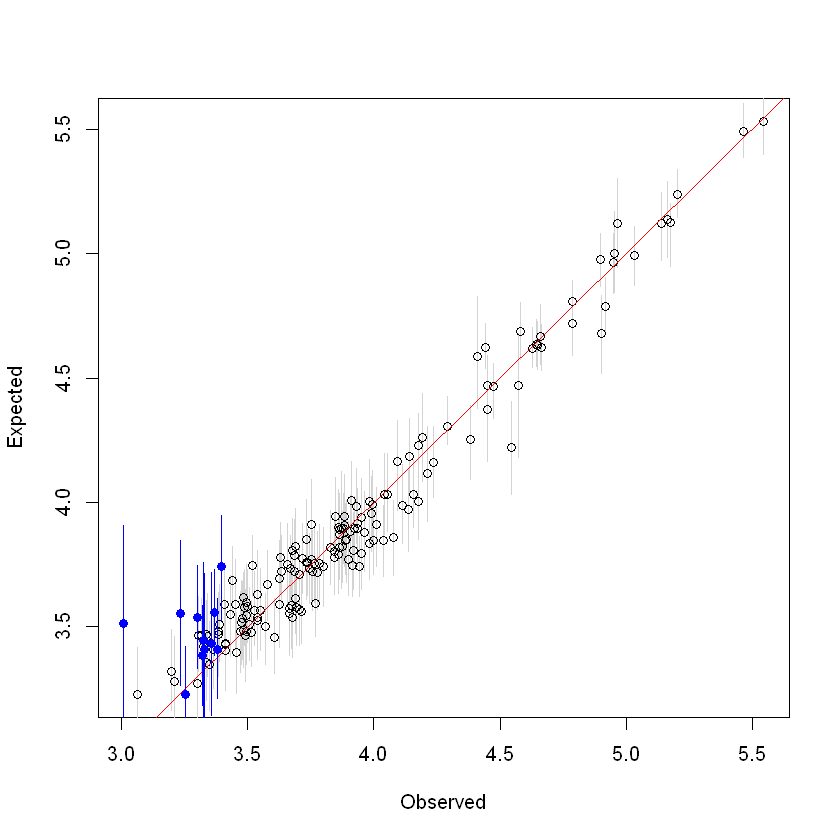

In [4]:
####################
# Predictions
myPredictions <- predict(myModel)

dim(myPredictions)
head(myPredictions)

####################
# Prediction plot
plot(myModel, what=".obsvpred")


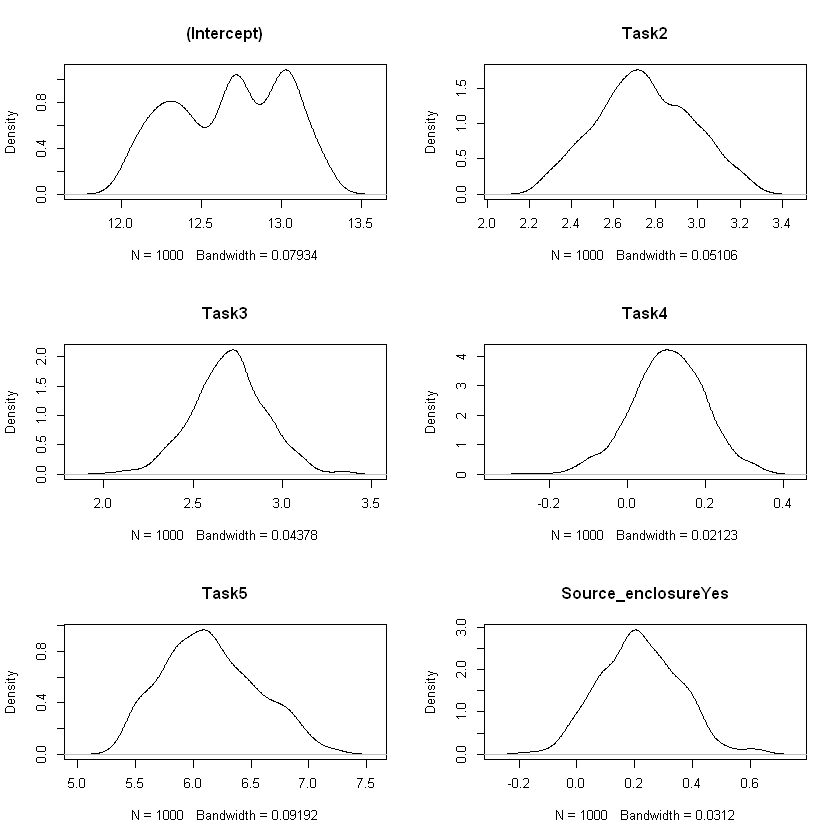

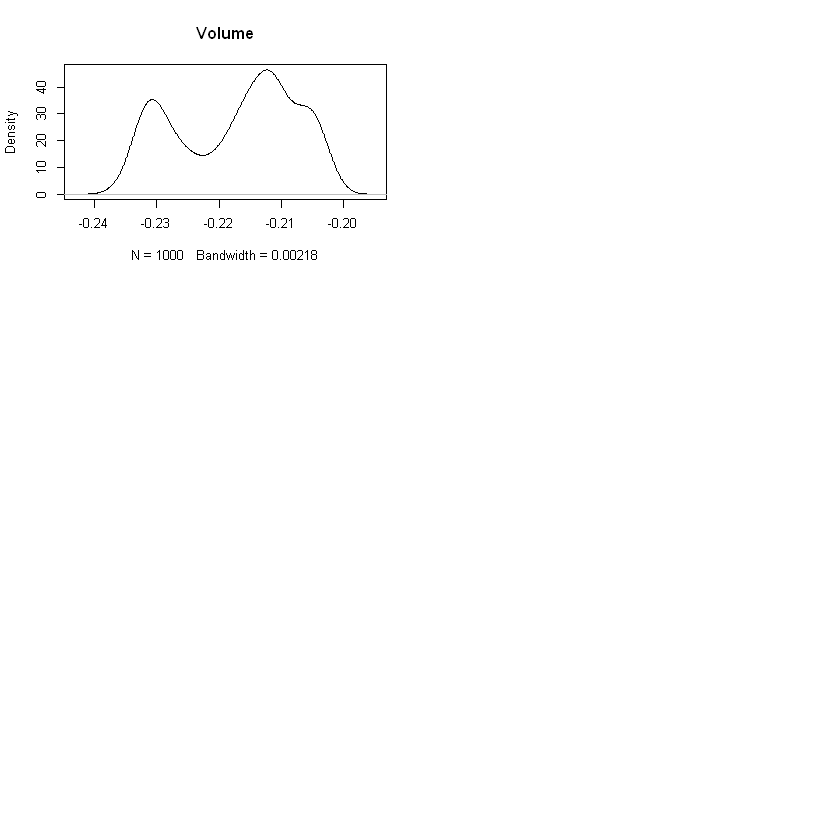

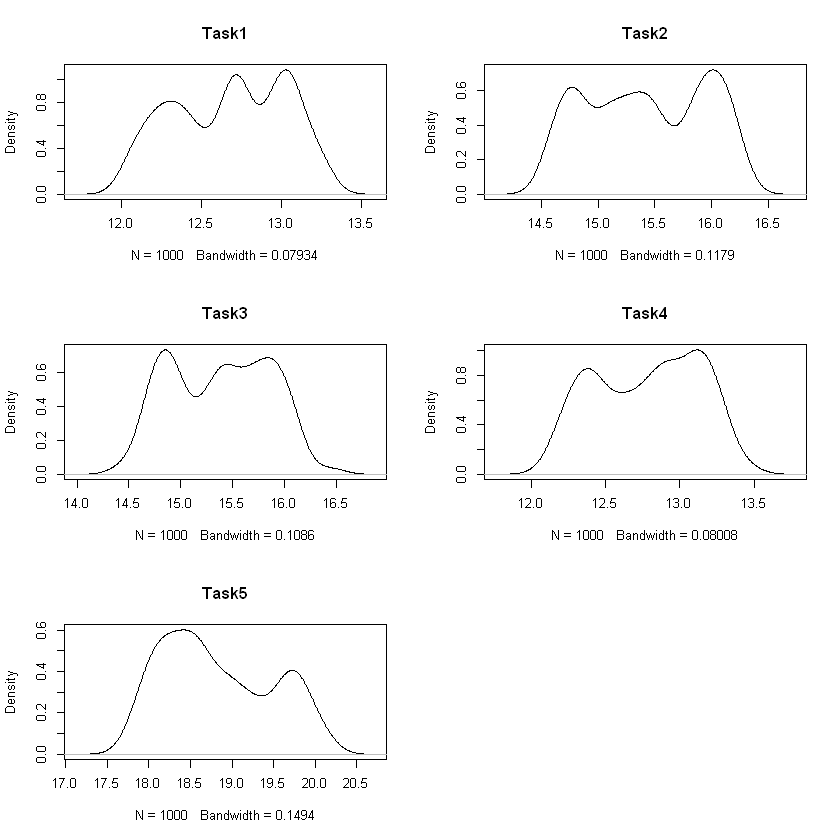

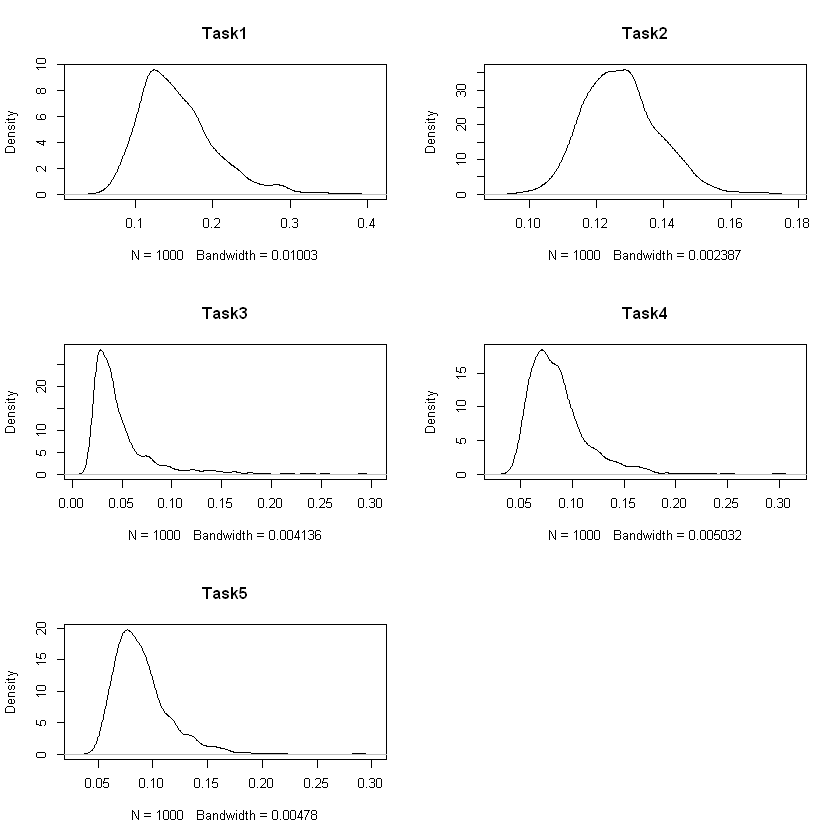

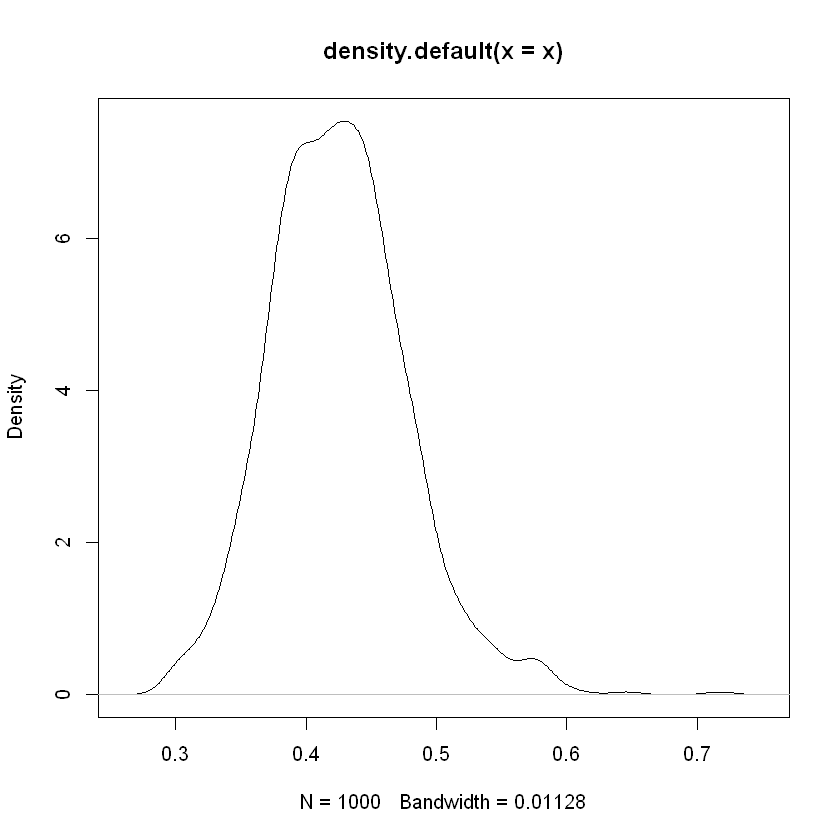

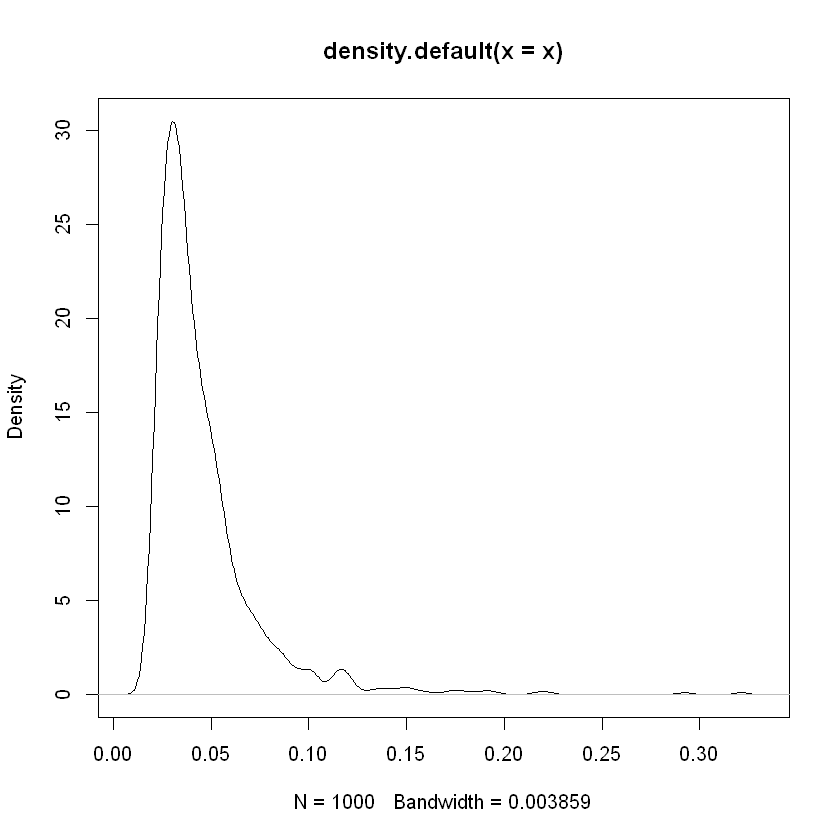

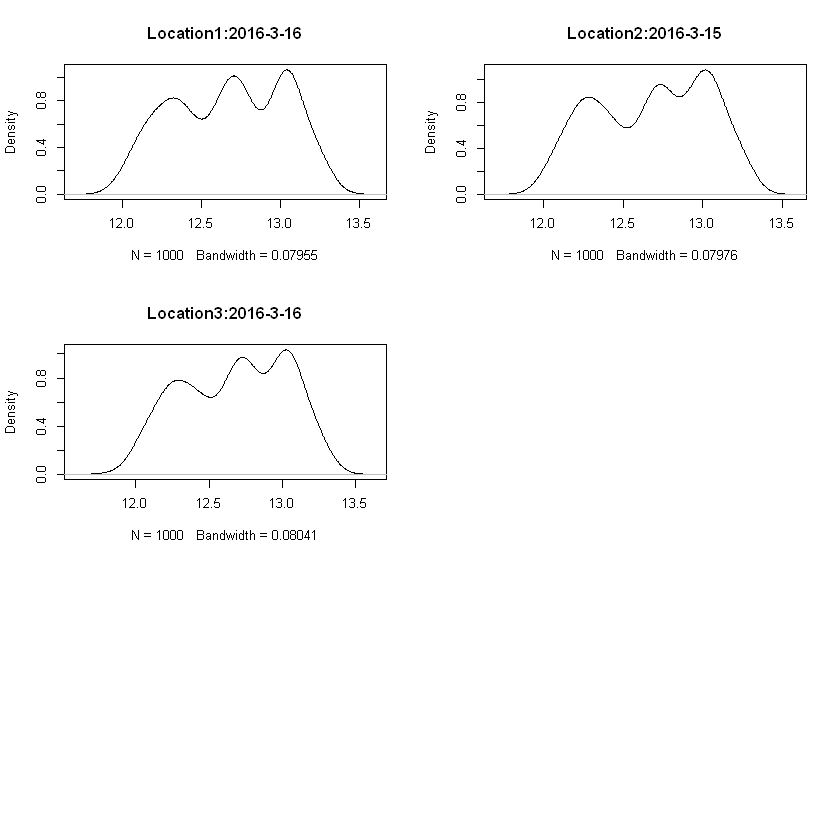

In [5]:

####################
# Density plots
plot(myModel, what=".density.coefs", panels=c(3,2))

plot(myModel, what=".density.tasks", panels=c(3,2))

plot(myModel, what=".density.sdEpsilon", panels=c(3,2))

plot(myModel, what=".density.sdZeta")

plot(myModel, what=".density.sdAlpha")

plot(myModel, what=".density.random", panels=c(3,2))

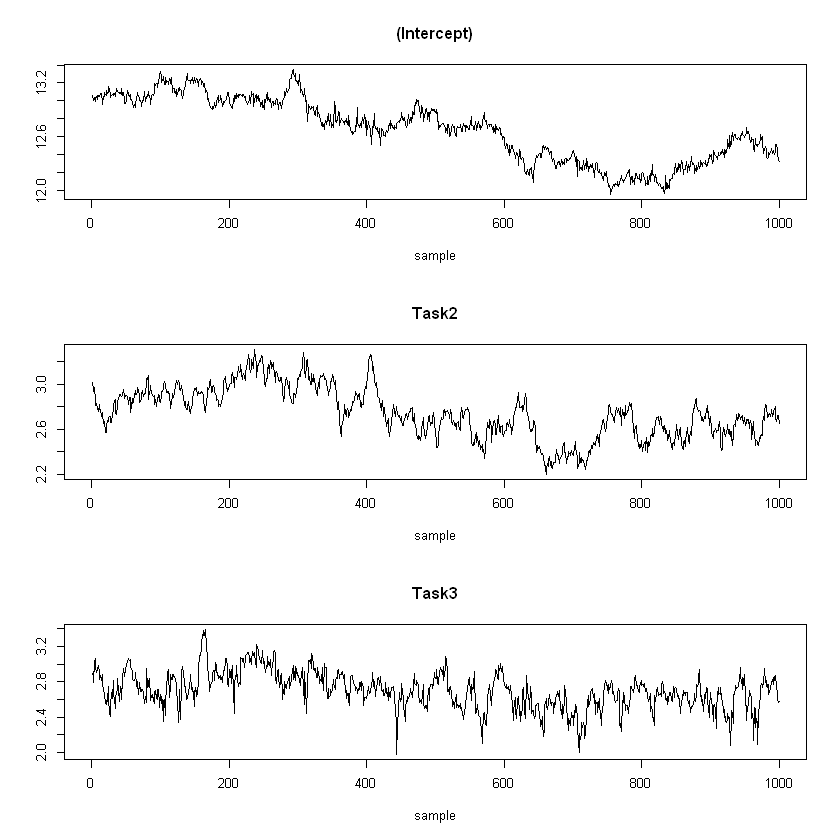

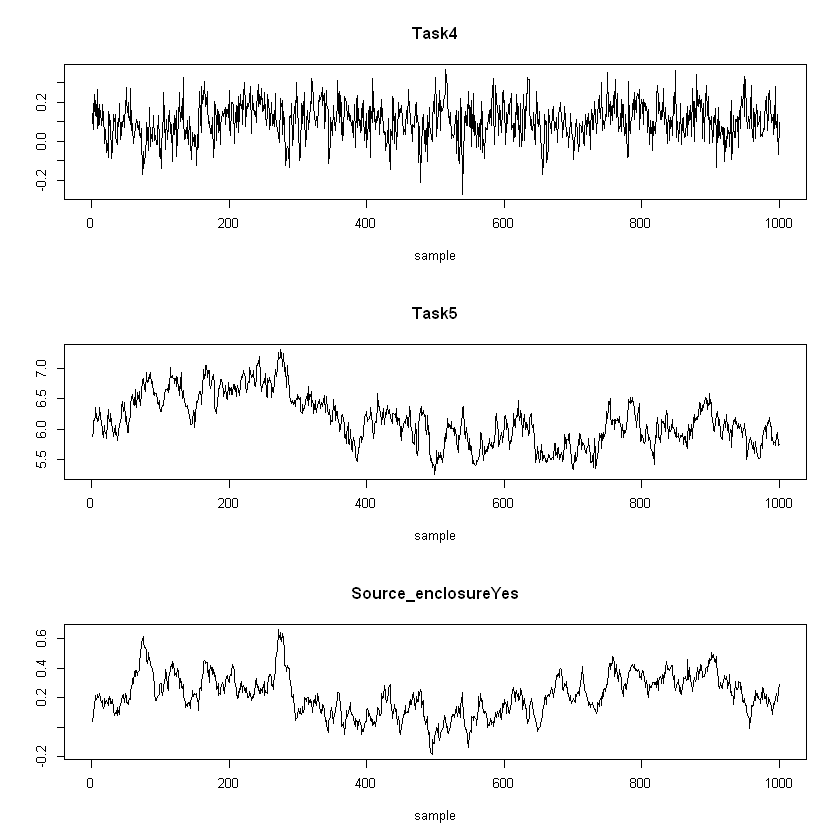

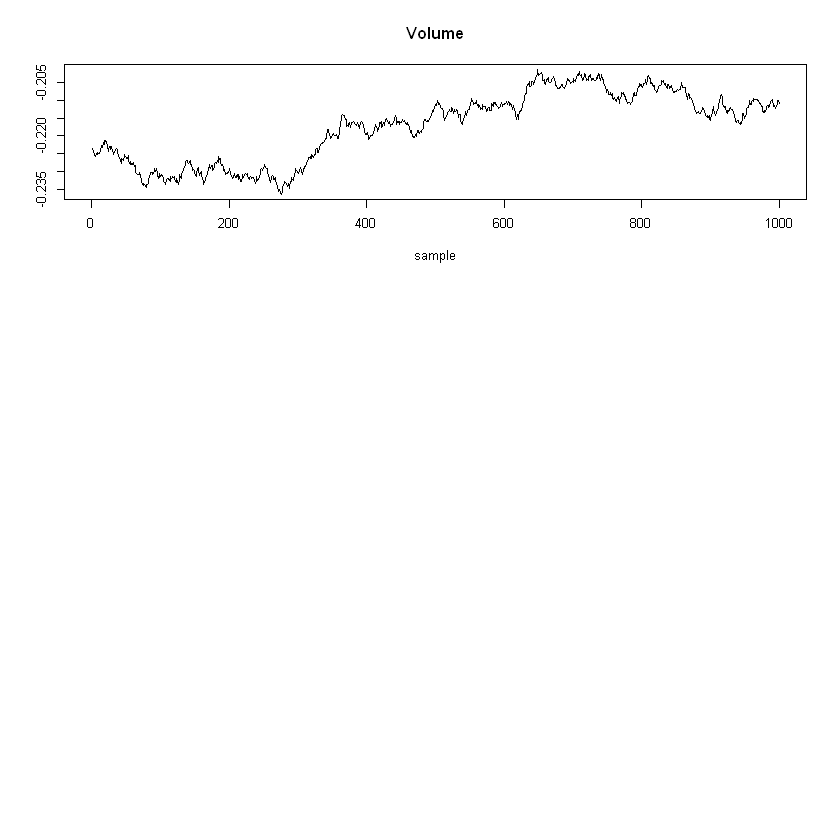

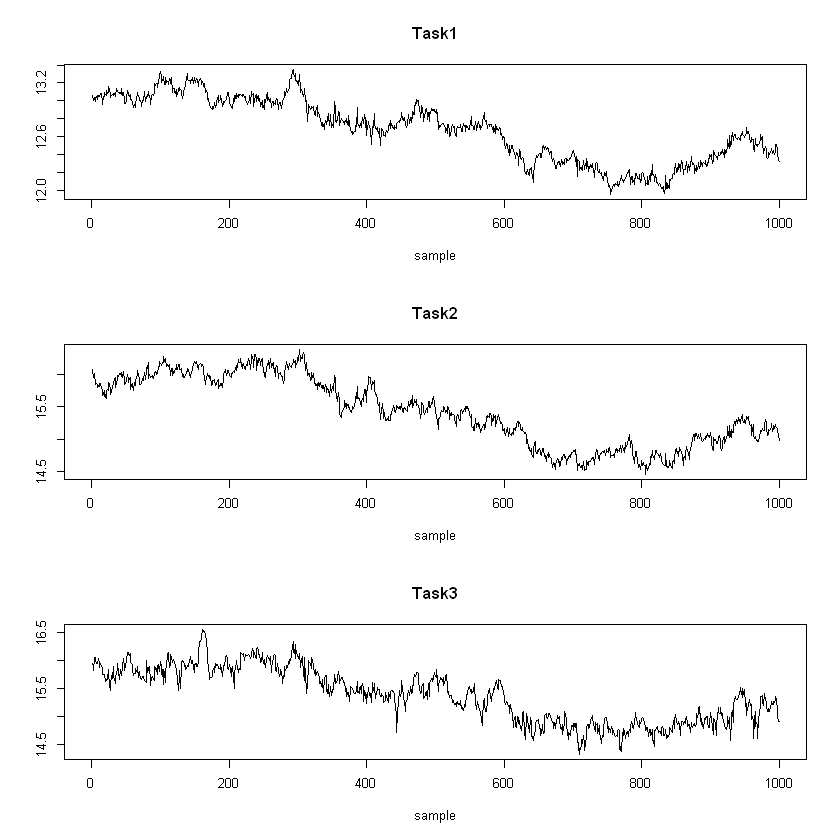

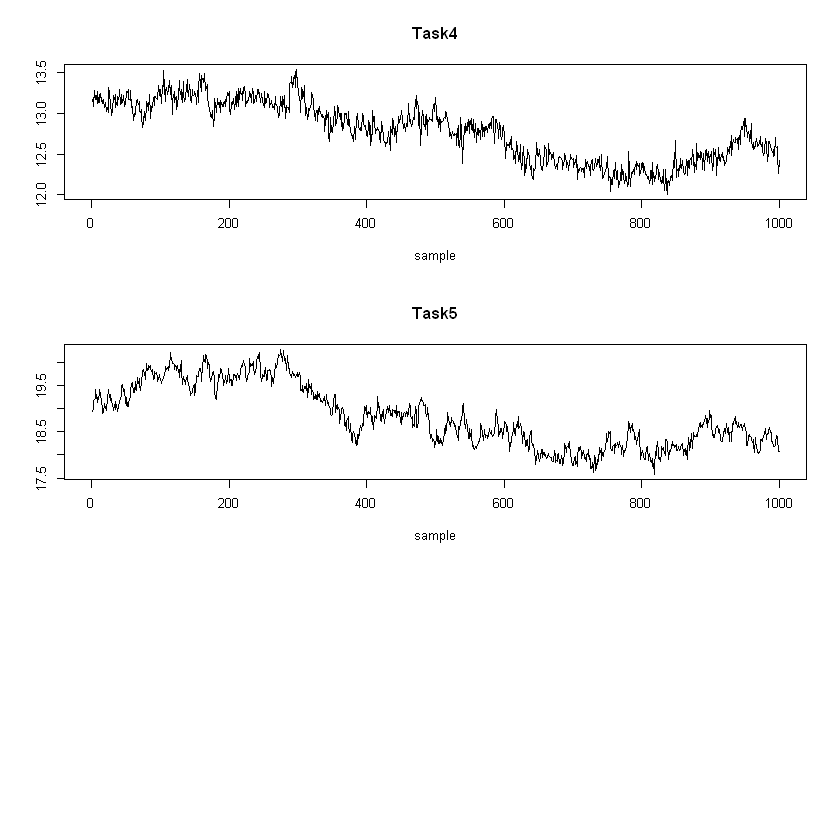

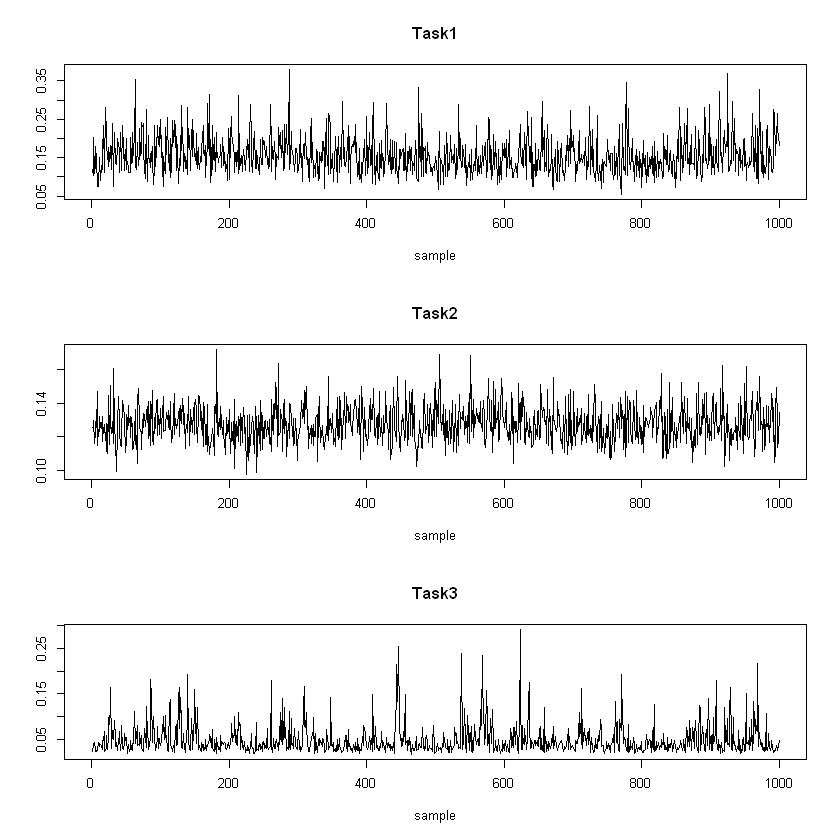

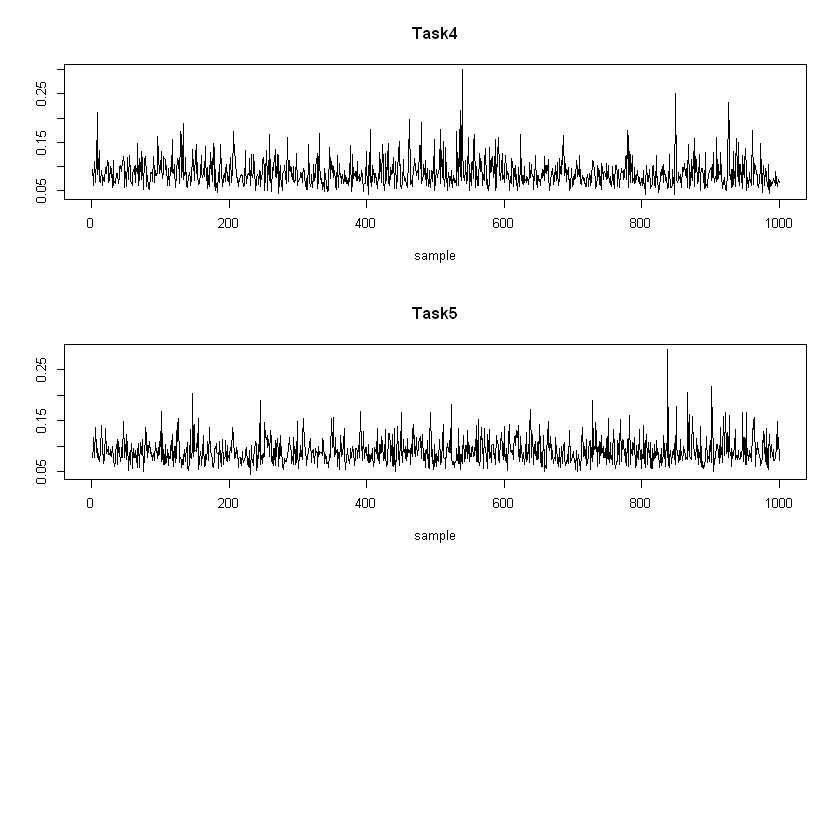

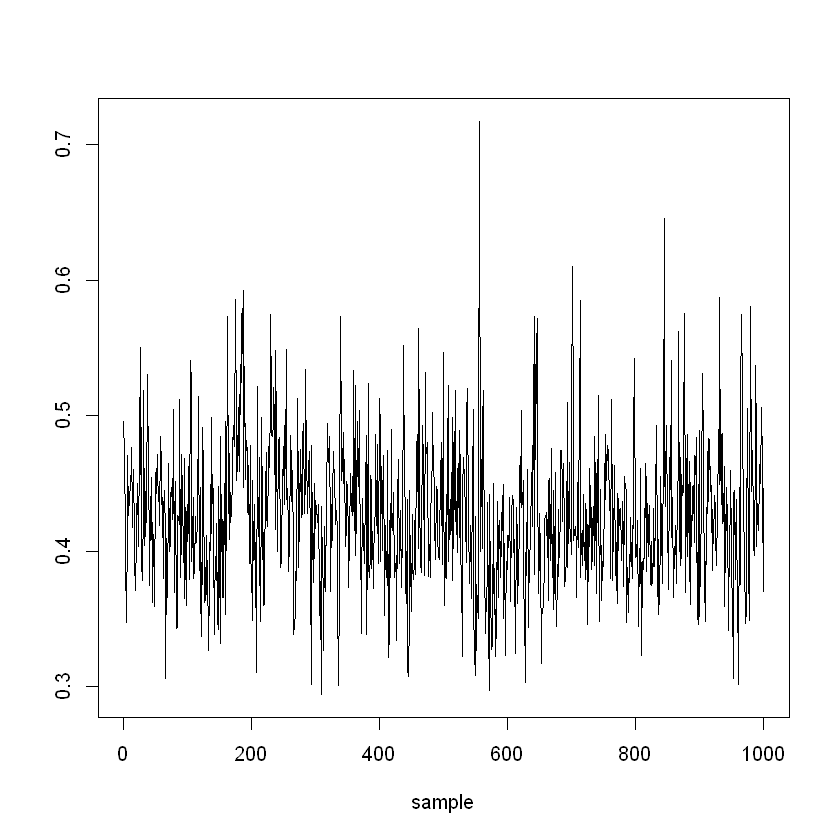

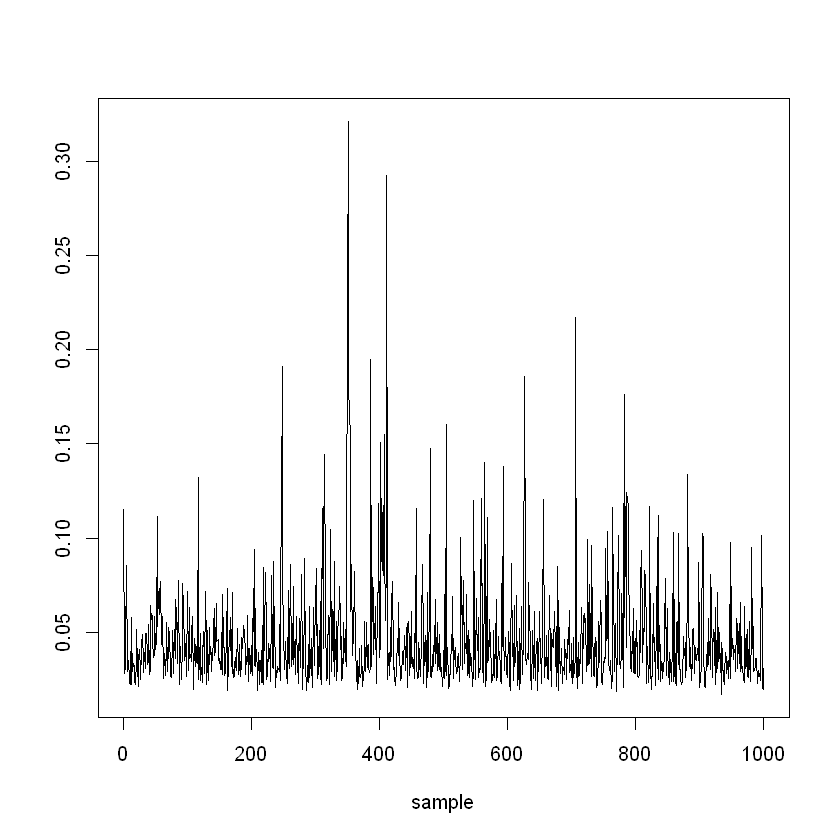

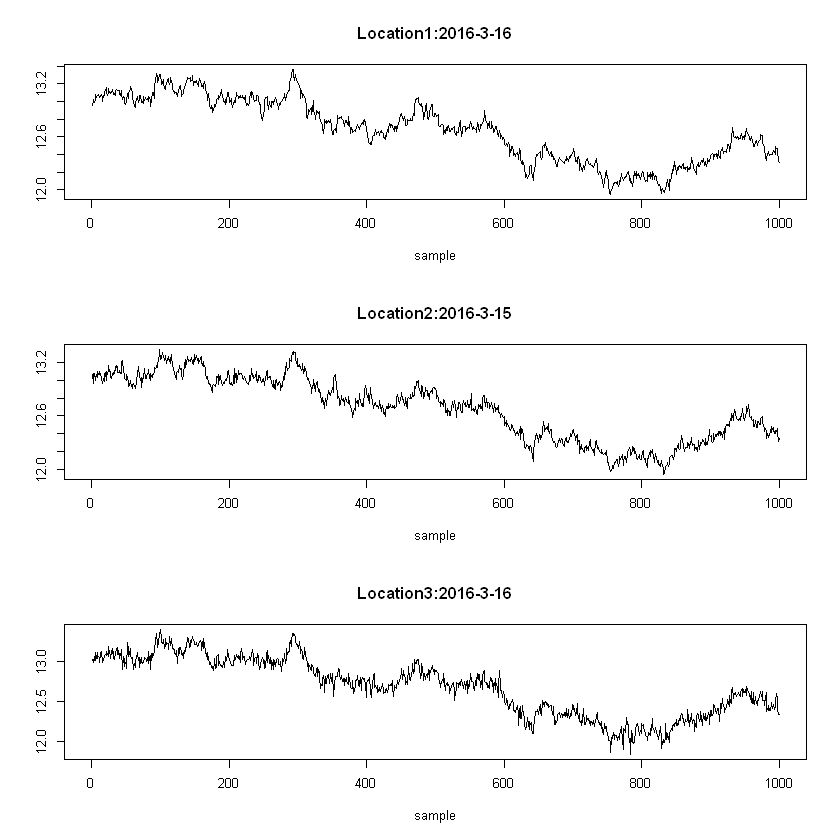

In [6]:
####################
# Trace plots
plot(myModel, what=".trace.coefs")

plot(myModel, what=".trace.tasks")

plot(myModel, what=".trace.sdEpsilon")

plot(myModel, what=".trace.sdZeta")

plot(myModel, what=".trace.sdAlpha")

plot(myModel, what=".trace.random")

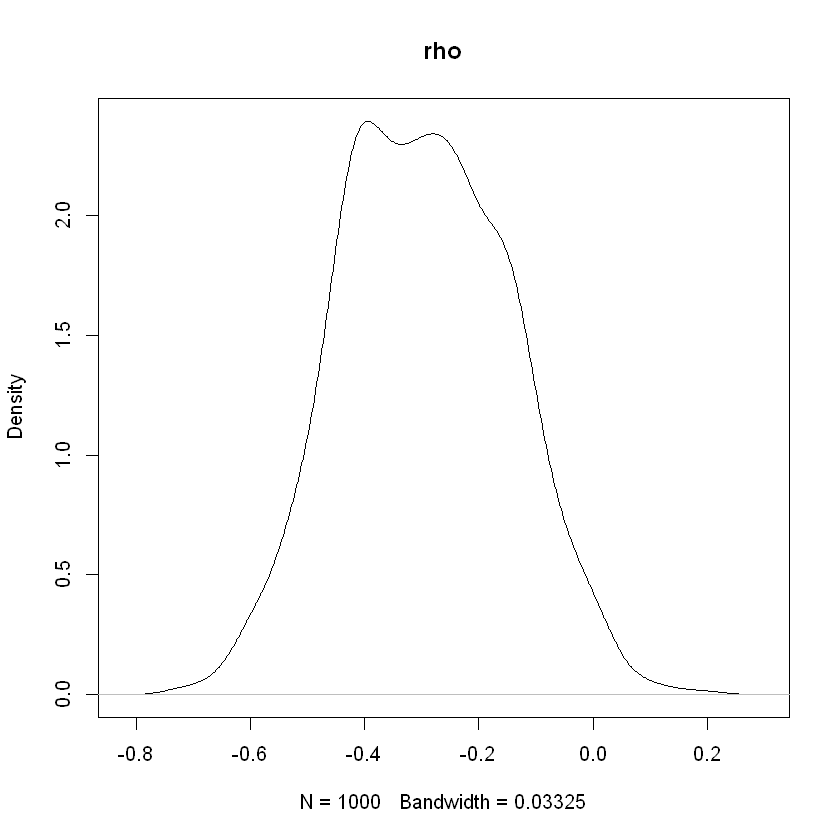

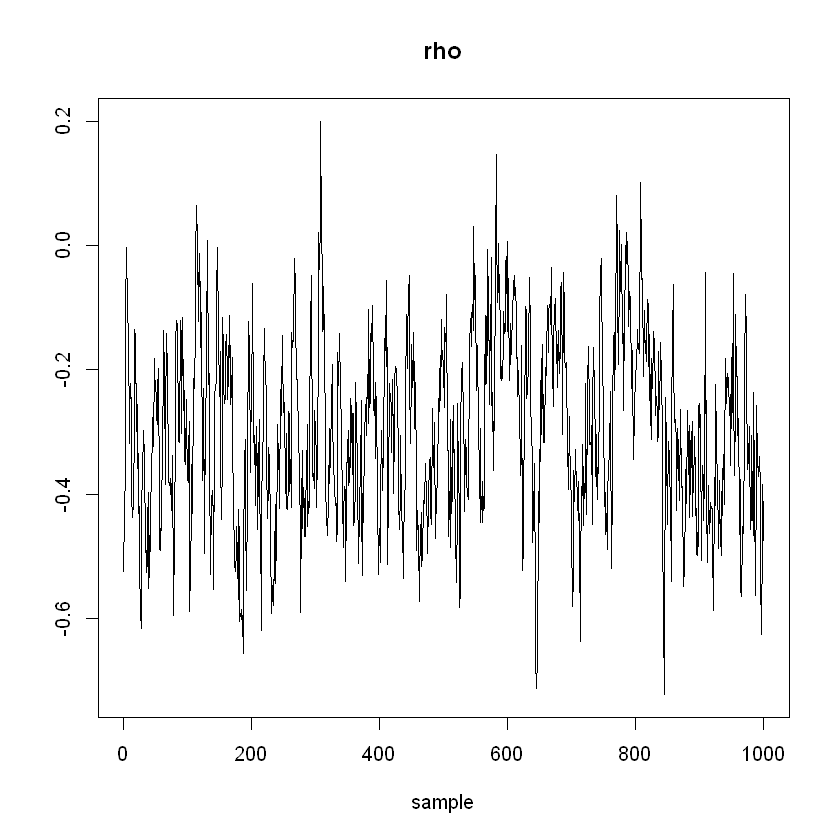

In [7]:
####################
# Show posterior distribution of autocorrelation parameter
post.rho = getVariableBlock(myModel, "rho")
colnames(post.rho) = 'rho'
rtxmDensityPlot(post.rho,panels=1)
rtxmTracePlot(post.rho,panels=1)